In [1]:
import math
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from catboost import CatBoostClassifier

from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import (ExtraTreesClassifier, ExtraTreesRegressor,
                              GradientBoostingRegressor,
                              RandomForestClassifier, RandomForestRegressor,
                              StackingClassifier)
from sklearn.linear_model import (LinearRegression, LogisticRegression,
                                  SGDClassifier, SGDRegressor)

from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             classification_report, confusion_matrix, f1_score,
                             matthews_corrcoef, mean_absolute_error,
                             mean_squared_error, r2_score)
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_predict
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.svm import LinearSVC, LinearSVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from xgboost import XGBClassifier, XGBRegressor

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
carne = pd.read_excel('../entrada/banco_carne_geracao_renda_pof17_v2.xls')
carne.columns

Index(['id', 'idfam', 'UF', 'ESTRATO_POF', 'TIPO_SITUACAO_REG', 'COD_UPA',
       'NUM_DOM', 'NUM_UC', 'COD_INFORMANTE', 'V0306', 'V0403', 'V0404',
       'V0405', 'V0406', 'V0407', 'V0409', 'V0410', 'V0411', 'V0412', 'V0414',
       'ANOS_ESTUDO', 'PESO', 'PESO_FINAL', 'RENDA_TOTAL', 'dom', '_merge',
       'V0201', 'V0202', 'V0203', 'V0204', 'V0205', 'V0206', 'V0207', 'V0209',
       'V02111', 'V02113', 'V0212', 'V0213', 'V02141', 'V0215', 'V02161',
       'V02162', 'V02163', 'V02164', 'V0217', 'V0220', 'V0221', 'V6199', 'san',
       '_merge6', 'idade', 'V04023', 'sexo', 'V0425', 'rpc', 'bov2_final',
       'cp_final', 'porco_final', 'cordeiro_final', 'frango_final',
       'peixe_final', 'caca_mi_final', 'ENERGIA_KCAL', 'seguranca_alimentar',
       'bov_adj', 'cp_adj', 'porco_adj', 'cordeiro_adj', 'frango_adj',
       'peixe_adj', 'caca_adj', 'meat_total_crude', 'meat_total_adj',
       'geracoes', '_merge7', 'supplem', 'dieta', 'V71051', 'V71052', 'V71053',
       'V71054', 'V710

In [4]:
# domt show floats as scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 100)

In [5]:

carne['id'] = carne['id'].astype(str)
carne.head()


,id,idfam,UF,ESTRATO_POF,TIPO_SITUACAO_REG,COD_UPA,NUM_DOM,NUM_UC,COD_INFORMANTE,V0306,V0403,V0404,V0405,V0406,V0407,V0409,V0410,V0411,V0412,V0414,ANOS_ESTUDO,PESO,PESO_FINAL,RENDA_TOTAL,dom,_merge,V0201,V0202,V0203,V0204,V0205,V0206,V0207,V0209,V02111,V02113,V0212,V0213,V02141,V0215,V02161,V02162,V02163,V02164,V0217,V0220,V0221,V6199,san,_merge6,idade,V04023,sexo,V0425,rpc,bov2_final,cp_final,porco_final,cordeiro_final,frango_final,peixe_final,caca_mi_final,ENERGIA_KCAL,seguranca_alimentar,bov_adj,cp_adj,porco_adj,cordeiro_adj,frango_adj,peixe_adj,caca_adj,meat_total_crude,meat_total_adj,geracoes,_merge7,supplem,dieta,V71051,V71052,V71053,V71054,V71055,V71056,gravida,amamenta,pesokg,altura,imc
0,11000001602101,110000016021,11,1101,1,110000016,2,1,1,1,64,1,4,2,1.000,0.000,1.000,0.000,NaN,1,5,449.912,690.884,3855.340,110000016020,both in master and using data,1,1,1,3,6,2,1,1,2,NaN,2.000,1,1,1.000,1,2,1,2,2,1,1,1,1,both in master and using data,64,1953,Homem,Antigo primário,1285.110,83.125,0.000,0.000,0.000,0.000,0.000,0.000,1382.300,SAN,60.135,0.000,0.000,0.000,0.000,0.000,0.000,83.125,60.135,baby boomers,both in master and using data,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64,154,26.986
1,11000001602102,110000016021,11,1101,1,110000016,2,1,2,2,61,2,4,2,1.000,1.000,1.000,0.000,NaN,1,6,449.912,690.884,3855.340,110000016020,both in master and using data,1,1,1,3,6,2,1,1,2,NaN,2.000,1,1,1.000,1,2,1,2,2,1,1,1,1,both in master and using data,61,1956,Mulher,Antigo primário,1285.110,66.500,0.000,0.000,0.000,0.000,0.000,0.000,1228.800,SAN,54.118,0.000,0.000,0.000,0.000,0.000,0.000,66.500,54.118,baby boomers,both in master and using data,2,2,NaN,NaN,NaN,NaN,NaN,NaN,2.000,2.000,53,144,25.559
2,11000001602103,110000016021,11,1101,1,110000016,2,1,3,6,41,1,4,2,1.000,1.000,1.000,0.000,NaN,1,12,449.912,690.884,3855.340,110000016020,both in master and using data,1,1,1,3,6,2,1,1,2,NaN,2.000,1,1,1.000,1,2,1,2,2,1,1,1,1,both in master and using data,41,1976,Homem,Regular do ensino médio,1285.110,166.250,0.000,0.000,0.000,0.000,0.000,0.000,1351.950,SAN,122.971,0.000,0.000,0.000,0.000,0.000,0.000,166.250,122.971,geracao X,both in master and using data,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80,180,24.691
3,11000001607101,110000016071,11,1101,1,110000016,7,1,1,1,37,1,4,2,1.000,4.000,1.000,1.000,2.000,1,12,449.912,690.884,6253.240,110000016070,both in master and using data,1,1,1,1,8,3,1,1,2,NaN,2.000,1,1,1.000,1,2,1,2,1,1,1,1,1,both in master and using data,37,1980,Homem,Regular do ensino médio,1250.650,82.431,50.000,0.000,0.000,0.000,0.000,0.000,2012.395,SAN,40.962,24.846,0.000,0.000,0.000,0.000,0.000,132.431,65.808,geracao Y,both in master and using data,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76,168,26.927
4,11000001607102,110000016071,11,1101,1,110000016,7,1,2,2,36,2,4,1,1.000,0.000,2.000,1.000,2.000,1,12,449.912,690.884,6253.240,110000016070,both in master and using data,1,1,1,1,8,3,1,1,2,NaN,2.000,1,1,1.000,1,2,1,2,1,1,1,1,1,both in master and using data,36,1981,Mulher,Regular do ensino médio,1250.650,41.215,25.000,0.000,0.000,0.000,0.000,0.000,1607.382,SAN,25.641,15.553,0.000,0.000,0.000,0.000,0.000,66.215,41.195,geracao Y,both in master and using data,1,2,NaN,NaN,NaN,NaN,NaN,NaN,2.000,2.000,58,145,27.586


In [6]:
# create a new column caled "pessoas_na_familia" that will count how many people live in each family (consider each family as a unique id from idfam)
carne['pessoas_na_familia'] = carne.groupby('idfam')['idfam'].transform('count')
carne['pessoas_na_familia'].value_counts()

pessoas_na_familia
2     15618
3     12330
4      7716
1      5371
5      3120
6      1122
7       448
8       272
9       126
10       30
11       11
Name: count, dtype: int64

In [7]:
dropping = [i for i in carne.columns if '_final' in i]
dropping += [i for i in carne.columns if '_merge' in i]
#dropping += ['meat_total_adj', 'meat_total_crude']
dropping += ['V71051', 'V71052', 'V71053', 'V71054', 'V71055', 'V71056'] # tipos de dieta, excluir
dropping += ['V04023'] # ano nascimento
#dropping += ['gravida', 'amamenta', 'pesokg', 'altura']
dropping += ['san', 'V6199']
dropping += ['V02113']
#dropping += ['PESO', 'COD_INFORMANTE', 'ESTRATO_POF', 'COD_UPA', 'NUM_DOM', 'NUM_UC', 'PESO_FINAL', 'rpc']
dropping += ['V0403', 'V0404', 'V0412', 'geracoes', 'V0425', 'V0411', 'V0215']
dropping += ['id', 'dom']
print(dropping)
df = carne.drop(columns=dropping).copy()
df




['bov2_final', 'cp_final', 'porco_final', 'cordeiro_final', 'frango_final', 'peixe_final', 'caca_mi_final', '_merge', '_merge6', '_merge7', 'V71051', 'V71052', 'V71053', 'V71054', 'V71055', 'V71056', 'V04023', 'san', 'V6199', 'V02113', 'V0403', 'V0404', 'V0412', 'geracoes', 'V0425', 'V0411', 'V0215', 'id', 'dom']


,idfam,UF,ESTRATO_POF,TIPO_SITUACAO_REG,COD_UPA,NUM_DOM,NUM_UC,COD_INFORMANTE,V0306,V0405,V0406,V0407,V0409,V0410,V0414,ANOS_ESTUDO,PESO,PESO_FINAL,RENDA_TOTAL,V0201,V0202,V0203,V0204,V0205,V0206,V0207,V0209,V02111,V0212,V0213,V02141,V02161,V02162,V02163,V02164,V0217,V0220,V0221,idade,sexo,rpc,ENERGIA_KCAL,seguranca_alimentar,bov_adj,cp_adj,porco_adj,cordeiro_adj,frango_adj,peixe_adj,caca_adj,meat_total_crude,meat_total_adj,supplem,dieta,gravida,amamenta,pesokg,altura,imc,pessoas_na_familia
0,110000016021,11,1101,1,110000016,2,1,1,1,4,2,1.000,0.000,1.000,1,5,449.912,690.884,3855.340,1,1,1,3,6,2,1,1,2,2.000,1,1,1,2,1,2,2,1,1,64,Homem,1285.110,1382.300,SAN,60.135,0.000,0.000,0.000,0.000,0.000,0.000,83.125,60.135,2,2,NaN,NaN,64,154,26.986,3
1,110000016021,11,1101,1,110000016,2,1,2,2,4,2,1.000,1.000,1.000,1,6,449.912,690.884,3855.340,1,1,1,3,6,2,1,1,2,2.000,1,1,1,2,1,2,2,1,1,61,Mulher,1285.110,1228.800,SAN,54.118,0.000,0.000,0.000,0.000,0.000,0.000,66.500,54.118,2,2,2.000,2.000,53,144,25.559,3
2,110000016021,11,1101,1,110000016,2,1,3,6,4,2,1.000,1.000,1.000,1,12,449.912,690.884,3855.340,1,1,1,3,6,2,1,1,2,2.000,1,1,1,2,1,2,2,1,1,41,Homem,1285.110,1351.950,SAN,122.971,0.000,0.000,0.000,0.000,0.000,0.000,166.250,122.971,2,2,NaN,NaN,80,180,24.691,3
3,110000016071,11,1101,1,110000016,7,1,1,1,4,2,1.000,4.000,1.000,1,12,449.912,690.884,6253.240,1,1,1,1,8,3,1,1,2,2.000,1,1,1,2,1,2,1,1,1,37,Homem,1250.650,2012.395,SAN,40.962,24.846,0.000,0.000,0.000,0.000,0.000,132.431,65.808,2,2,NaN,NaN,76,168,26.927,4
4,110000016071,11,1101,1,110000016,7,1,2,2,4,1,1.000,0.000,2.000,1,12,449.912,690.884,6253.240,1,1,1,1,8,3,1,1,2,2.000,1,1,1,2,1,2,1,1,1,36,Mulher,1250.650,1607.382,SAN,25.641,15.553,0.000,0.000,0.000,0.000,0.000,66.215,41.195,1,2,2.000,2.000,58,145,27.586,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46159,530044198031,53,5301,1,530044198,3,1,4,4,4,1,2.000,0.000,0.000,1,12,563.080,689.626,35197.600,2,1,3,2,11,3,1,1,3,1.000,1,1,1,2,1,2,4,1,1,17,Mulher,8799.400,2539.870,SAN,13.718,0.000,0.000,0.000,60.771,0.000,0.000,189.193,74.489,2,2,2.000,2.000,93,166,33.749,3
46160,530044198091,53,5301,1,530044198,9,1,1,1,4,1,2.000,1.000,1.000,1,15,563.080,689.626,31051.450,2,1,3,2,12,2,1,1,3,1.000,1,1,1,2,1,2,4,1,1,41,Mulher,10350.480,1099.733,SAN,0.000,0.000,0.000,0.000,103.255,12.730,0.000,127.553,115.985,2,1,2.000,2.000,86,163,32.369,2
46161,530044198091,53,5301,1,530044198,9,1,2,2,1,1,1.000,1.000,2.000,1,16,563.080,689.626,31051.450,2,1,3,2,12,2,1,1,3,1.000,1,1,1,2,1,2,4,1,1,52,Homem,10350.480,1459.200,SAN,0.000,7.281,0.000,0.000,0.000,68.222,0.000,110.175,75.504,2,2,NaN,NaN,64,163,24.088,2
46162,530044198111,53,5301,1,530044198,11,1,1,1,4,1,1.000,1.000,1.000,1,16,563.080,689.626,1569.030,2,1,3,1,4,1,1,1,1,1.000,1,1,1,2,1,2,3,1,1,25,Mulher,1569.030,2041.750,SAN,37.113,0.000,0.000,0.000,0.000,0.000,0.000,75.775,37.113,2,2,2.000,2.000,49,157,19.879,1


In [8]:
df.dropna(how='any')

,idfam,UF,ESTRATO_POF,TIPO_SITUACAO_REG,COD_UPA,NUM_DOM,NUM_UC,COD_INFORMANTE,V0306,V0405,V0406,V0407,V0409,V0410,V0414,ANOS_ESTUDO,PESO,PESO_FINAL,RENDA_TOTAL,V0201,V0202,V0203,V0204,V0205,V0206,V0207,V0209,V02111,V0212,V0213,V02141,V02161,V02162,V02163,V02164,V0217,V0220,V0221,idade,sexo,rpc,ENERGIA_KCAL,seguranca_alimentar,bov_adj,cp_adj,porco_adj,cordeiro_adj,frango_adj,peixe_adj,caca_adj,meat_total_crude,meat_total_adj,supplem,dieta,gravida,amamenta,pesokg,altura,imc,pessoas_na_familia
1,110000016021,11,1101,1,110000016,2,1,2,2,4,2,1.000,1.000,1.000,1,6,449.912,690.884,3855.340,1,1,1,3,6,2,1,1,2,2.000,1,1,1,2,1,2,2,1,1,61,Mulher,1285.110,1228.800,SAN,54.118,0.000,0.000,0.000,0.000,0.000,0.000,66.500,54.118,2,2,2.000,2.000,53,144,25.559,3
4,110000016071,11,1101,1,110000016,7,1,2,2,4,1,1.000,0.000,2.000,1,12,449.912,690.884,6253.240,1,1,1,1,8,3,1,1,2,2.000,1,1,1,2,1,2,1,1,1,36,Mulher,1250.650,1607.382,SAN,25.641,15.553,0.000,0.000,0.000,0.000,0.000,66.215,41.195,1,2,2.000,2.000,58,145,27.586,4
6,110000016071,11,1101,1,110000016,7,1,5,6,4,2,1.000,0.000,1.000,1,12,449.912,690.884,6253.240,1,1,1,1,8,3,1,1,2,2.000,1,1,1,2,1,2,1,1,1,19,Mulher,1250.650,1681.495,SAN,24.511,14.868,0.000,0.000,0.000,0.000,0.000,66.215,39.379,2,2,2.000,2.000,47,155,19.563,4
7,110000016121,11,1101,1,110000016,12,1,2,2,4,2,1.000,1.000,0.000,1,11,449.912,690.884,4353.510,1,1,1,1,6,3,2,1,1,2.000,1,1,1,2,2,2,3,1,1,32,Mulher,1088.380,1872.344,SAN,2.233,0.000,0.000,0.000,80.714,0.000,0.000,155.304,82.946,2,2,2.000,2.000,57,151,24.999,2
8,110000016121,11,1101,1,110000016,12,1,3,6,4,2,2.000,0.000,0.000,1,5,449.912,690.884,4353.510,1,1,1,1,6,3,2,1,1,2.000,1,1,1,2,2,2,3,1,1,14,Mulher,1088.380,2020.950,SAN,68.993,0.000,0.000,0.000,49.852,0.000,0.000,240.180,118.845,2,2,2.000,2.000,54,145,25.684,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46154,530044198021,53,5301,1,530044198,2,1,2,2,1,1,1.000,0.000,0.000,1,15,563.080,689.626,24739.800,2,1,3,2,10,3,1,1,3,1.000,1,1,1,2,1,2,4,1,1,50,Mulher,4947.960,1072.490,SAN,44.289,0.000,0.000,0.000,46.970,0.000,0.000,97.874,91.259,2,1,2.000,2.000,85,164,31.603,4
46158,530044198031,53,5301,1,530044198,3,1,3,4,4,1,2.000,0.000,0.000,1,8,563.080,689.626,35197.600,2,1,3,2,11,3,1,1,3,1.000,1,1,1,2,1,2,4,1,1,14,Mulher,8799.400,1832.710,SAN,19.011,0.000,0.000,0.000,56.146,0.000,0.000,137.743,75.158,2,2,2.000,2.000,52,161,20.061,3
46159,530044198031,53,5301,1,530044198,3,1,4,4,4,1,2.000,0.000,0.000,1,12,563.080,689.626,35197.600,2,1,3,2,11,3,1,1,3,1.000,1,1,1,2,1,2,4,1,1,17,Mulher,8799.400,2539.870,SAN,13.718,0.000,0.000,0.000,60.771,0.000,0.000,189.193,74.489,2,2,2.000,2.000,93,166,33.749,3
46160,530044198091,53,5301,1,530044198,9,1,1,1,4,1,2.000,1.000,1.000,1,15,563.080,689.626,31051.450,2,1,3,2,12,2,1,1,3,1.000,1,1,1,2,1,2,4,1,1,41,Mulher,10350.480,1099.733,SAN,0.000,0.000,0.000,0.000,103.255,12.730,0.000,127.553,115.985,2,1,2.000,2.000,86,163,32.369,2


In [9]:
df['V0409'] = df['V0409'].fillna(0).astype(int)
df['V0410'] = df['V0410'].fillna(0).astype(int)
df['V0212'] = df['V0212'].fillna(0).astype(int)


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46164 entries, 0 to 46163
Data columns (total 60 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   idfam                46164 non-null  int64  
 1   UF                   46164 non-null  int64  
 2   ESTRATO_POF          46164 non-null  int64  
 3   TIPO_SITUACAO_REG    46164 non-null  int64  
 4   COD_UPA              46164 non-null  int64  
 5   NUM_DOM              46164 non-null  int64  
 6   NUM_UC               46164 non-null  int64  
 7   COD_INFORMANTE       46164 non-null  int64  
 8   V0306                46164 non-null  int64  
 9   V0405                46164 non-null  int64  
 10  V0406                46164 non-null  int64  
 11  V0407                46150 non-null  float64
 12  V0409                46164 non-null  int64  
 13  V0410                46164 non-null  int64  
 14  V0414                46164 non-null  int64  
 15  ANOS_ESTUDO          46164 non-null 

In [11]:
df.drop(columns=['gravida', 'amamenta'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(46164, 58)

In [12]:
print(df.shape)
df = df.dropna(how='any').copy()
print(df.shape)

# Reduzindo o tamanho porque a relação custo benefício de tirar as colunas dos NaNs não compensa. É melhor manter as colunas e eliminar as 4% de linhas finais (já que vamos considerar 1 pessoa por familia)
# < 0.0001% das familias fica de fora

(46164, 58)
(46150, 58)


In [13]:
df.columns

Index(['idfam', 'UF', 'ESTRATO_POF', 'TIPO_SITUACAO_REG', 'COD_UPA', 'NUM_DOM',
       'NUM_UC', 'COD_INFORMANTE', 'V0306', 'V0405', 'V0406', 'V0407', 'V0409',
       'V0410', 'V0414', 'ANOS_ESTUDO', 'PESO', 'PESO_FINAL', 'RENDA_TOTAL',
       'V0201', 'V0202', 'V0203', 'V0204', 'V0205', 'V0206', 'V0207', 'V0209',
       'V02111', 'V0212', 'V0213', 'V02141', 'V02161', 'V02162', 'V02163',
       'V02164', 'V0217', 'V0220', 'V0221', 'idade', 'sexo', 'rpc',
       'ENERGIA_KCAL', 'seguranca_alimentar', 'bov_adj', 'cp_adj', 'porco_adj',
       'cordeiro_adj', 'frango_adj', 'peixe_adj', 'caca_adj',
       'meat_total_crude', 'meat_total_adj', 'supplem', 'dieta', 'pesokg',
       'altura', 'imc', 'pessoas_na_familia'],
      dtype='object')

In [14]:
df = df[['idfam', 'UF', 'TIPO_SITUACAO_REG', 
       'COD_INFORMANTE', 'V0405', 
       'V0414', 'ANOS_ESTUDO', 'idade', 'sexo', 'seguranca_alimentar', 'bov_adj', 'cp_adj', 'porco_adj',
       'cordeiro_adj', 'frango_adj', 'peixe_adj', 'caca_adj',
       'meat_total_adj', 'supplem', 'dieta',
       'imc', 'pessoas_na_familia']] # 'amamenta', 'pesokg', 'altura', 

In [15]:
df_renda = pd.read_parquet('saida/dados_8c_yes_onehot_corrigido.parquet')
df_renda = df_renda[['idfam', 'categoria_renda_corrigida']]

df = df.merge(df_renda, on='idfam', how='inner')

In [16]:
df

,idfam,UF,TIPO_SITUACAO_REG,COD_INFORMANTE,V0405,V0414,ANOS_ESTUDO,idade,sexo,seguranca_alimentar,bov_adj,cp_adj,porco_adj,cordeiro_adj,frango_adj,peixe_adj,caca_adj,meat_total_adj,supplem,dieta,imc,pessoas_na_familia,categoria_renda_corrigida
0,110000016021,11,1,1,4,1,5,64,Homem,SAN,60.135,0.000,0.000,0.000,0.000,0.000,0.000,60.135,2,2,26.986,3,4
1,110000016021,11,1,2,4,1,6,61,Mulher,SAN,54.118,0.000,0.000,0.000,0.000,0.000,0.000,54.118,2,2,25.559,3,4
2,110000016021,11,1,3,4,1,12,41,Homem,SAN,122.971,0.000,0.000,0.000,0.000,0.000,0.000,122.971,2,2,24.691,3,4
3,110000016071,11,1,1,4,1,12,37,Homem,SAN,40.962,24.846,0.000,0.000,0.000,0.000,0.000,65.808,2,2,26.927,4,4
4,110000016071,11,1,2,4,1,12,36,Mulher,SAN,25.641,15.553,0.000,0.000,0.000,0.000,0.000,41.195,1,2,27.586,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46145,530044198031,53,1,4,4,1,12,17,Mulher,SAN,13.718,0.000,0.000,0.000,60.771,0.000,0.000,74.489,2,2,33.749,3,7
46146,530044198091,53,1,1,4,1,15,41,Mulher,SAN,0.000,0.000,0.000,0.000,103.255,12.730,0.000,115.985,2,1,32.369,2,7
46147,530044198091,53,1,2,1,1,16,52,Homem,SAN,0.000,7.281,0.000,0.000,0.000,68.222,0.000,75.504,2,2,24.088,2,7
46148,530044198111,53,1,1,4,1,16,25,Mulher,SAN,37.113,0.000,0.000,0.000,0.000,0.000,0.000,37.113,2,2,19.879,1,4


In [17]:
# [
# ["V0405", "Cor ou raça"],
# ["1", "Branca"],
# ["2", "Preta"],
# ["3", "Amarela"],
# ["4", "Parda"],
# ["5", "Indígena"],
# ["9", "Sem declaração"],
# ],

df['is_white'] = df['V0405'].apply(lambda x: True if x == 1 else False)
df.drop(columns=['V0405'], inplace=True)
df

,idfam,UF,TIPO_SITUACAO_REG,COD_INFORMANTE,V0414,ANOS_ESTUDO,idade,sexo,seguranca_alimentar,bov_adj,cp_adj,porco_adj,cordeiro_adj,frango_adj,peixe_adj,caca_adj,meat_total_adj,supplem,dieta,imc,pessoas_na_familia,categoria_renda_corrigida,is_white
0,110000016021,11,1,1,1,5,64,Homem,SAN,60.135,0.000,0.000,0.000,0.000,0.000,0.000,60.135,2,2,26.986,3,4,False
1,110000016021,11,1,2,1,6,61,Mulher,SAN,54.118,0.000,0.000,0.000,0.000,0.000,0.000,54.118,2,2,25.559,3,4,False
2,110000016021,11,1,3,1,12,41,Homem,SAN,122.971,0.000,0.000,0.000,0.000,0.000,0.000,122.971,2,2,24.691,3,4,False
3,110000016071,11,1,1,1,12,37,Homem,SAN,40.962,24.846,0.000,0.000,0.000,0.000,0.000,65.808,2,2,26.927,4,4,False
4,110000016071,11,1,2,1,12,36,Mulher,SAN,25.641,15.553,0.000,0.000,0.000,0.000,0.000,41.195,1,2,27.586,4,4,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46145,530044198031,53,1,4,1,12,17,Mulher,SAN,13.718,0.000,0.000,0.000,60.771,0.000,0.000,74.489,2,2,33.749,3,7,False
46146,530044198091,53,1,1,1,15,41,Mulher,SAN,0.000,0.000,0.000,0.000,103.255,12.730,0.000,115.985,2,1,32.369,2,7,False
46147,530044198091,53,1,2,1,16,52,Homem,SAN,0.000,7.281,0.000,0.000,0.000,68.222,0.000,75.504,2,2,24.088,2,7,True
46148,530044198111,53,1,1,1,16,25,Mulher,SAN,37.113,0.000,0.000,0.000,0.000,0.000,0.000,37.113,2,2,19.879,1,4,False


In [18]:
df['can_read'] = df['V0414'].apply(lambda x: True if x == 1 else False)
df.drop(columns=['V0414'], inplace=True)
df

,idfam,UF,TIPO_SITUACAO_REG,COD_INFORMANTE,ANOS_ESTUDO,idade,sexo,seguranca_alimentar,bov_adj,cp_adj,porco_adj,cordeiro_adj,frango_adj,peixe_adj,caca_adj,meat_total_adj,supplem,dieta,imc,pessoas_na_familia,categoria_renda_corrigida,is_white,can_read
0,110000016021,11,1,1,5,64,Homem,SAN,60.135,0.000,0.000,0.000,0.000,0.000,0.000,60.135,2,2,26.986,3,4,False,True
1,110000016021,11,1,2,6,61,Mulher,SAN,54.118,0.000,0.000,0.000,0.000,0.000,0.000,54.118,2,2,25.559,3,4,False,True
2,110000016021,11,1,3,12,41,Homem,SAN,122.971,0.000,0.000,0.000,0.000,0.000,0.000,122.971,2,2,24.691,3,4,False,True
3,110000016071,11,1,1,12,37,Homem,SAN,40.962,24.846,0.000,0.000,0.000,0.000,0.000,65.808,2,2,26.927,4,4,False,True
4,110000016071,11,1,2,12,36,Mulher,SAN,25.641,15.553,0.000,0.000,0.000,0.000,0.000,41.195,1,2,27.586,4,4,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46145,530044198031,53,1,4,12,17,Mulher,SAN,13.718,0.000,0.000,0.000,60.771,0.000,0.000,74.489,2,2,33.749,3,7,False,True
46146,530044198091,53,1,1,15,41,Mulher,SAN,0.000,0.000,0.000,0.000,103.255,12.730,0.000,115.985,2,1,32.369,2,7,False,True
46147,530044198091,53,1,2,16,52,Homem,SAN,0.000,7.281,0.000,0.000,0.000,68.222,0.000,75.504,2,2,24.088,2,7,True,True
46148,530044198111,53,1,1,16,25,Mulher,SAN,37.113,0.000,0.000,0.000,0.000,0.000,0.000,37.113,2,2,19.879,1,4,False,True


In [19]:
df['dieta'] = df['dieta'].apply(lambda x: True if x == 1 else False)

df['supplem'] = df['supplem'].apply(lambda x: True if x == 1 else False)
df

,idfam,UF,TIPO_SITUACAO_REG,COD_INFORMANTE,ANOS_ESTUDO,idade,sexo,seguranca_alimentar,bov_adj,cp_adj,porco_adj,cordeiro_adj,frango_adj,peixe_adj,caca_adj,meat_total_adj,supplem,dieta,imc,pessoas_na_familia,categoria_renda_corrigida,is_white,can_read
0,110000016021,11,1,1,5,64,Homem,SAN,60.135,0.000,0.000,0.000,0.000,0.000,0.000,60.135,False,False,26.986,3,4,False,True
1,110000016021,11,1,2,6,61,Mulher,SAN,54.118,0.000,0.000,0.000,0.000,0.000,0.000,54.118,False,False,25.559,3,4,False,True
2,110000016021,11,1,3,12,41,Homem,SAN,122.971,0.000,0.000,0.000,0.000,0.000,0.000,122.971,False,False,24.691,3,4,False,True
3,110000016071,11,1,1,12,37,Homem,SAN,40.962,24.846,0.000,0.000,0.000,0.000,0.000,65.808,False,False,26.927,4,4,False,True
4,110000016071,11,1,2,12,36,Mulher,SAN,25.641,15.553,0.000,0.000,0.000,0.000,0.000,41.195,True,False,27.586,4,4,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46145,530044198031,53,1,4,12,17,Mulher,SAN,13.718,0.000,0.000,0.000,60.771,0.000,0.000,74.489,False,False,33.749,3,7,False,True
46146,530044198091,53,1,1,15,41,Mulher,SAN,0.000,0.000,0.000,0.000,103.255,12.730,0.000,115.985,False,True,32.369,2,7,False,True
46147,530044198091,53,1,2,16,52,Homem,SAN,0.000,7.281,0.000,0.000,0.000,68.222,0.000,75.504,False,False,24.088,2,7,True,True
46148,530044198111,53,1,1,16,25,Mulher,SAN,37.113,0.000,0.000,0.000,0.000,0.000,0.000,37.113,False,False,19.879,1,4,False,True


In [20]:
df['is_urban'] = df['TIPO_SITUACAO_REG'].apply(lambda x: True if x == 1 else False)
df.drop(columns=['TIPO_SITUACAO_REG'], inplace=True)
df


,idfam,UF,COD_INFORMANTE,ANOS_ESTUDO,idade,sexo,seguranca_alimentar,bov_adj,cp_adj,porco_adj,cordeiro_adj,frango_adj,peixe_adj,caca_adj,meat_total_adj,supplem,dieta,imc,pessoas_na_familia,categoria_renda_corrigida,is_white,can_read,is_urban
0,110000016021,11,1,5,64,Homem,SAN,60.135,0.000,0.000,0.000,0.000,0.000,0.000,60.135,False,False,26.986,3,4,False,True,True
1,110000016021,11,2,6,61,Mulher,SAN,54.118,0.000,0.000,0.000,0.000,0.000,0.000,54.118,False,False,25.559,3,4,False,True,True
2,110000016021,11,3,12,41,Homem,SAN,122.971,0.000,0.000,0.000,0.000,0.000,0.000,122.971,False,False,24.691,3,4,False,True,True
3,110000016071,11,1,12,37,Homem,SAN,40.962,24.846,0.000,0.000,0.000,0.000,0.000,65.808,False,False,26.927,4,4,False,True,True
4,110000016071,11,2,12,36,Mulher,SAN,25.641,15.553,0.000,0.000,0.000,0.000,0.000,41.195,True,False,27.586,4,4,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46145,530044198031,53,4,12,17,Mulher,SAN,13.718,0.000,0.000,0.000,60.771,0.000,0.000,74.489,False,False,33.749,3,7,False,True,True
46146,530044198091,53,1,15,41,Mulher,SAN,0.000,0.000,0.000,0.000,103.255,12.730,0.000,115.985,False,True,32.369,2,7,False,True,True
46147,530044198091,53,2,16,52,Homem,SAN,0.000,7.281,0.000,0.000,0.000,68.222,0.000,75.504,False,False,24.088,2,7,True,True,True
46148,530044198111,53,1,16,25,Mulher,SAN,37.113,0.000,0.000,0.000,0.000,0.000,0.000,37.113,False,False,19.879,1,4,False,True,True


In [22]:
df['is_woman'] = df['sexo'].apply(lambda x: True if x == 'Mulher' else False)
df.drop(columns=['sexo'], inplace=True)
df

,idfam,UF,COD_INFORMANTE,ANOS_ESTUDO,idade,seguranca_alimentar,bov_adj,cp_adj,porco_adj,cordeiro_adj,frango_adj,peixe_adj,caca_adj,meat_total_adj,supplem,dieta,imc,pessoas_na_familia,categoria_renda_corrigida,is_white,can_read,is_urban,is_woman
0,110000016021,11,1,5,64,SAN,60.135,0.000,0.000,0.000,0.000,0.000,0.000,60.135,False,False,26.986,3,4,False,True,True,False
1,110000016021,11,2,6,61,SAN,54.118,0.000,0.000,0.000,0.000,0.000,0.000,54.118,False,False,25.559,3,4,False,True,True,True
2,110000016021,11,3,12,41,SAN,122.971,0.000,0.000,0.000,0.000,0.000,0.000,122.971,False,False,24.691,3,4,False,True,True,False
3,110000016071,11,1,12,37,SAN,40.962,24.846,0.000,0.000,0.000,0.000,0.000,65.808,False,False,26.927,4,4,False,True,True,False
4,110000016071,11,2,12,36,SAN,25.641,15.553,0.000,0.000,0.000,0.000,0.000,41.195,True,False,27.586,4,4,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46145,530044198031,53,4,12,17,SAN,13.718,0.000,0.000,0.000,60.771,0.000,0.000,74.489,False,False,33.749,3,7,False,True,True,True
46146,530044198091,53,1,15,41,SAN,0.000,0.000,0.000,0.000,103.255,12.730,0.000,115.985,False,True,32.369,2,7,False,True,True,True
46147,530044198091,53,2,16,52,SAN,0.000,7.281,0.000,0.000,0.000,68.222,0.000,75.504,False,False,24.088,2,7,True,True,True,False
46148,530044198111,53,1,16,25,SAN,37.113,0.000,0.000,0.000,0.000,0.000,0.000,37.113,False,False,19.879,1,4,False,True,True,True


In [23]:
# TOTAL
# BRANCA (PEIXE, FRANGO)
# VERMELHA (BOI, PORCO, caprino)

df['meat_white_adj'] = df['peixe_adj'] + df['frango_adj']
df['meat_red_adj'] = df['bov_adj'] + df['porco_adj'] + df['cordeiro_adj']

In [24]:
df.columns

Index(['idfam', 'UF', 'COD_INFORMANTE', 'ANOS_ESTUDO', 'idade',
       'seguranca_alimentar', 'bov_adj', 'cp_adj', 'porco_adj', 'cordeiro_adj',
       'frango_adj', 'peixe_adj', 'caca_adj', 'meat_total_adj', 'supplem',
       'dieta', 'imc', 'pessoas_na_familia', 'categoria_renda_corrigida',
       'is_white', 'can_read', 'is_urban', 'is_woman', 'meat_white_adj',
       'meat_red_adj'],
      dtype='object')

In [25]:
df = df[['idade', 'is_woman', 'meat_white_adj','meat_red_adj', 'meat_total_adj']]

features = ['idade', 'is_woman']
targets = ['meat_white_adj','meat_red_adj', 'meat_total_adj']

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
import math
from sklearn.model_selection import KFold
dict_targets = {}

kfold = KFold(n_splits=10, shuffle=True, random_state=314)
for target in targets:
    print(target)
    X = df[features]
    y = df[target]

    model = LinearRegression()
    preds = cross_val_predict(model, X, y, cv=kfold)
    r2 = r2_score(y, preds)
    rmse = math.sqrt(mean_squared_error(y, preds))
    model = LinearRegression()
    model.fit(X, y)
    dict_targets[target] = (model, r2, rmse, np.mean(y), np.std(y))

meat_white_adj
meat_red_adj
meat_total_adj


In [31]:
for k, v in dict_targets.items():
    print(k, v[1], v[2], v[3], v[4])

meat_white_adj 8.04046350183496e-05 57.894272372999836 44.30325633364325 57.89659999728451
meat_red_adj 0.004351682802513301 46.1775605024522 46.50728077685555 46.278364670796066
meat_total_adj 0.0027122708015130392 58.17585033630639 100.23966682532722 58.25490551710755


In [37]:
df[['idade', 'meat_white_adj','meat_red_adj', 'meat_total_adj']].corr()

,idade,meat_white_adj,meat_red_adj,meat_total_adj
idade,1.000,0.014,0.042,0.018
meat_white_adj,0.014,1.000,-0.356,0.671
meat_red_adj,0.042,-0.356,1.000,0.394
meat_total_adj,0.018,0.671,0.394,1.000


In [38]:
df[['is_woman', 'meat_white_adj','meat_red_adj', 'meat_total_adj']].corr()

,is_woman,meat_white_adj,meat_red_adj,meat_total_adj
is_woman,1.000,0.000,-0.051,-0.050
meat_white_adj,0.000,1.000,-0.356,0.671
meat_red_adj,-0.051,-0.356,1.000,0.394
meat_total_adj,-0.050,0.671,0.394,1.000


<Axes: xlabel='idade', ylabel='meat_white_adj'>

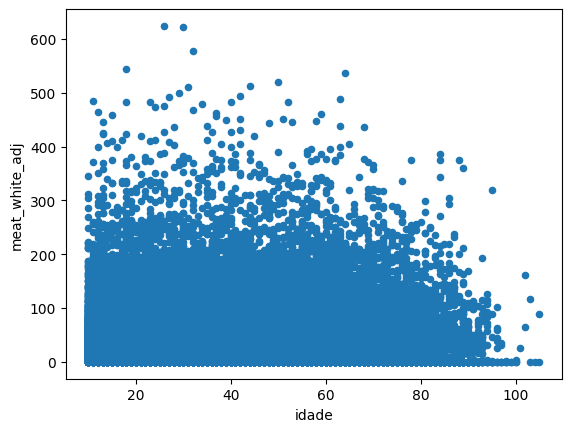

In [42]:
df[['idade', 'meat_white_adj']].plot.scatter(x='idade', y='meat_white_adj')

<Axes: xlabel='idade', ylabel='meat_red_adj'>

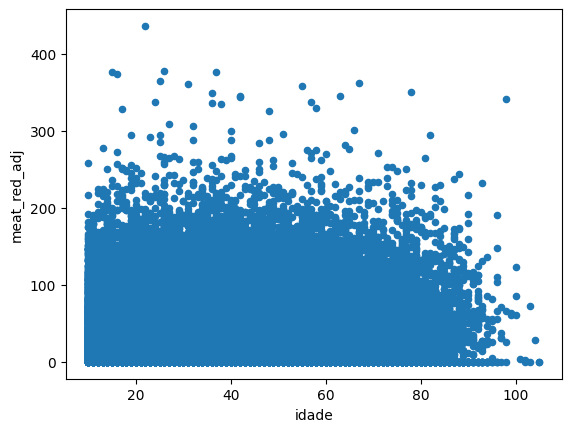

In [44]:
df[['idade', 'meat_red_adj']].plot.scatter(x='idade', y='meat_red_adj')

<Axes: xlabel='idade', ylabel='meat_total_adj'>

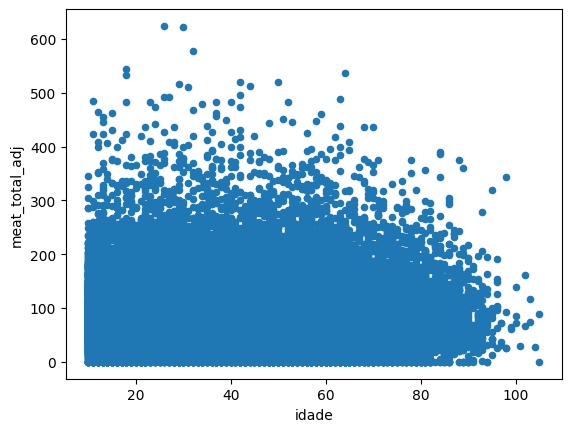

In [45]:
df[['idade', 'meat_total_adj']].plot.scatter(x='idade', y='meat_total_adj')

In [36]:
# see the importance of each feature
for k, v in dict_targets.items():
    print(k)
    # for i in range(len(features)):
    #     print(features[i], v[0].coef_[i])
    
    # rewrite the equation with the coefficients
    print('y = ', end='')
    for i in range(len(features)):
        print(f'({v[0].coef_[i]:.2f} * {features[i]}) + ', end='')
    print(f'({v[0].intercept_:.2f})')
    print()
    
    

meat_white_adj
y = (0.04 * idade) + (-0.03 * is_woman) + (42.63)

meat_red_adj
y = (0.10 * idade) + (-4.83 * is_woman) + (44.92)

meat_total_adj
y = (0.06 * idade) + (-5.92 * is_woman) + (101.06)

